In [97]:
import json
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import spacy as sp
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from spacy.tokens import Doc

%matplotlib inline

In [2]:
# Vantage news API Key
with open('./env', mode='r', encoding='utf-8') as f:
    api_key = f.readline().split('=')[-1]

# 30 days of financial news (FREE tier only allows for 25 requests/day, hence, only 25 days of data is collected).
for i in range(30):
    time_from = f'202212{'0' + str(i + 1) if i + 1 < 10 else str(i + 1)}T0001'
    time_to = f'202212{'0' + str(i + 2) if i + 2 < 10 else str(i + 2)}T0000'

    print(f'{time_from} - {time_to}')
    # ticker = 'MSFT'
    url = f'https://www.alphavantage.co/query?function=NEWS_SENTIMENT&time_from={time_from}&time_to={time_to}&limit=1000&apikey={api_key}'
    r = requests.get(url, headers={
        'User-Agent': "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_14_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/73.0.3683.75 Safari/537.36",
        'Accept-Language': 'en-US,en;h=0.9'})
    data = r.json()
    
    # UNCOMMENT TO SAVE JSON, intended for one time download only.
    # with open(f'./data/data_{time_from}_{time_to}.json', 'w') as fp:
    #     json.dump(data, fp)


In [2]:
def read_json_files(dir: str, fname_filter=None) -> list:
    json_fnames = []
    for (_, _, fnames) in os.walk(dir):
        json_fnames.extend(fnames)
        break  # ensure only top level json files are read.

    filter_predicate = lambda name: name.startswith(fname_filter) and name.endswith('.json') if fname_filter else lambda \
            name: name.startswith(filter)
    json_fnames = list(filter(filter_predicate, json_fnames))

    json_data = []
    for fname in json_fnames:
        with open(f'{dir}/{fname}', 'r') as json_file:
            json_data.append(json.load(json_file))
    return json_data


json_data = read_json_files('./data', 'data')

Print the top-level and second-level structure of a json element.

In [3]:
keys = json_data[0].keys()
for k in list(keys):
    value = json_data[0][k]
    if type(value) == dict:
        print(f'{k}:')
        for attr in value.keys():
            print(f'\t{attr}')
    elif type(value) == list:
        print(f'{k}[0]:')
        print(f'\t{list(value[0].keys())}')
    else:
        print(f'{k}')


items
sentiment_score_definition
relevance_score_definition
feed[0]:
	['title', 'url', 'time_published', 'authors', 'summary', 'banner_image', 'source', 'category_within_source', 'source_domain', 'topics', 'overall_sentiment_score', 'overall_sentiment_label', 'ticker_sentiment']


In [63]:
def parse_vantage_api_data(json_data: list) -> pd.DataFrame:
    df_list = []
    for json_dict in json_data:
        for item in json_dict['feed']:
            item_dict = {'title': item['title'], 'time_published': item['time_published'], 'summary': item['summary'],
                         'overall_sentiment_label': item['overall_sentiment_label'],
                         'ticker_sentiment': item['ticker_sentiment']}
            df_list.append(item_dict)
    return pd.DataFrame(df_list)


data_df = parse_vantage_api_data(json_data)

In [16]:
data_df

,title,time_published,summary,overall_sentiment_label,ticker_sentiment
0,Used Auto Loan Payments Have Topped a Key Level,20221202T000000,Car buyers still face shortages and rising pri...,Neutral,[]
1,Exclusive: Republicans introduce legislation t...,20221201T235959,Republicans introduce legislation to thwart ES...,Neutral,[]
2,Bitcoin mining revenues fell 20% in November,20221201T235942,Bitcoin mining revenues fell 19.9% in November...,Neutral,"[{'ticker': 'CRYPTO:BTC', 'relevance_score': '..."
3,Mercantile Appoints New Members to Bank Board ...,20221201T235900,"GRAND RAPIDS, Mich., Dec. 1, 2022 /PRNewswire/...",Neutral,"[{'ticker': 'META', 'relevance_score': '0.0493..."
4,Nicholas Truglia served with 18-month prison s...,20221201T235817,"Nicholas Truglia, the 25-year-old hacker who l...",Neutral,[]
...,...,...,...,...,...
20473,Auto Expo to show EV might | The Financial Exp...,20221225T005000,Auto Expo to show EV might The Financial Expre...,Neutral,"[{'ticker': 'TTM', 'relevance_score': '0.06292..."
20474,"Chanda Kochhar, husband in CBI custody till Mo...",20221225T004000,"Chanda Kochhar, husband in CBI custody till Mo...",Neutral,"[{'ticker': 'IBN', 'relevance_score': '0.26610..."
20475,"Important January 17, 2023 Deadline Reminder: ...",20221225T003400,"RADNOR, Pa., Dec. 24, 2022 ( GLOBE NEWSWIRE ) ...",Neutral,"[{'ticker': 'OLPX', 'relevance_score': '0.5854..."
20476,Numerous Strategies Have Failed To Get Adverti...,20221225T001515,With Elon Musk agreeing to resign as CEO after...,Neutral,"[{'ticker': 'TSLA', 'relevance_score': '0.2653..."


In [64]:
data_df.shape

(20478, 5)

Parse, tokenize, and lemmatize

In [65]:
nlp = sp.load('en_core_web_sm', disable=['ner', 'parser'])  # NER not required for this task


def cleaning(doc: Doc) -> str:
    # Lemmatize and remove stopwords
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Filter news with fewer words
    if len(txt) > 2:
        return ' '.join(txt)


brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in data_df['summary'])

In [66]:
cleaned_txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]

In [67]:
df_cleaned = pd.DataFrame({'cleaned_text': cleaned_txt})
df_cleaned.shape

(20478, 1)

In [68]:
data_df.shape

(20478, 5)

In [69]:
df_cleaned

,cleaned_text
0,car buyer face shortage rise price
1,republicans introduce legislation thwart esg r...
2,bitcoin mining revenue fall november million a...
3,grand rapid mich dec prnewswire mercantile ban...
4,nicholas truglia year old hacker year plead gu...
...,...
20473,auto expo ev financial express
20474,chanda kochhar husband cbi custody till monday...
20475,radnor pa dec globe newswire law firm kessler ...
20476,elon musk agree resign ceo conduct twitter pol...


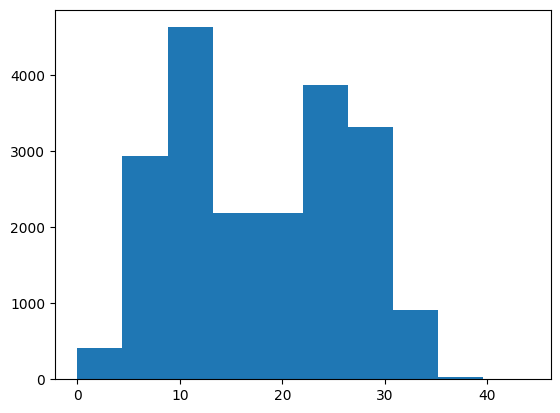

In [70]:
# Length distribution of each summary

text_len_dist = np.asarray([0 if sen is None else len(sen.split()) for sen in df_cleaned['cleaned_text']])

_ = plt.hist(text_len_dist)

In [71]:
print(f"Mean: {np.mean(text_len_dist)}")
print(f"Median: {np.median(text_len_dist)}")
print(f"Max: {np.max(text_len_dist)}")

Mean: 17.841732591073345
Median: 18.0
Max: 44


In [72]:
data_df['overall_sentiment_label'].unique()

array(['Neutral', 'Somewhat-Bullish', 'Bullish', 'Somewhat-Bearish',
       'Bearish'], dtype=object)

In [73]:
label_map = {
    'Bearish': 0,
    'Somewhat-Bearish': 1,
    'Neutral': 2,
    'Somewhat-Bullish': 3,
    'Bullish': 4,
}

for key in list(label_map.keys()):
    data_df.loc[data_df['overall_sentiment_label'] == key, 'overall_sentiment_label'] = label_map[key]

df_cleaned['overall_sentiment_label'] = data_df['overall_sentiment_label']
df_cleaned.dropna(inplace=True)
df_cleaned.reset_index(drop=True, inplace=True)

In [74]:
df_cleaned

,cleaned_text,overall_sentiment_label
0,car buyer face shortage rise price,2
1,republicans introduce legislation thwart esg r...,2
2,bitcoin mining revenue fall november million a...,2
3,grand rapid mich dec prnewswire mercantile ban...,2
4,nicholas truglia year old hacker year plead gu...,2
...,...,...
20360,auto expo ev financial express,2
20361,chanda kochhar husband cbi custody till monday...,2
20362,radnor pa dec globe newswire law firm kessler ...,2
20363,elon musk agree resign ceo conduct twitter pol...,2


In [76]:
# Preprocess News dataset
MAX_WORDS = 50
MIN_WORDS = 2


def doc_level_preprocess(doc):
    tokens = set(doc.split(" ")[:MAX_WORDS])
    if '' in tokens:
        tokens.remove('')
    return tokens


df_train = [(x, df_cleaned['overall_sentiment_label'][i]) for i, x in
            enumerate(map(doc_level_preprocess, df_cleaned['cleaned_text']))
            if len(x) >= MIN_WORDS]

In [77]:
df_train

[({'buyer', 'car', 'face', 'price', 'rise', 'shortage'}, 2),
 ({'business',
   'demand',
   'disclosure',
   'esg',
   'fox',
   'introduce',
   'legislation',
   'relate',
   'republicans',
   'sec',
   'thwart'},
  2),
 ({'accord',
   'aftermath',
   'bitcoin',
   'block',
   'collapse',
   'compile',
   'cryptocurrency',
   'datum',
   'fall',
   'ftx',
   'hang',
   'mark',
   'million',
   'mining',
   'month',
   'november',
   'price',
   'research',
   'revenue',
   'slump'},
  2),
 ({'amy',
   'announce',
   'appointment',
   'bank',
   'board',
   'corporation',
   'cpa',
   'dec',
   'director',
   'f',
   'grand',
   'half',
   'l',
   'mbwm',
   'mercantile',
   'mich',
   'nasdaq',
   'nelson',
   'prnewswire',
   'rapid',
   'sanchez',
   'second',
   'spark',
   'today'},
  2),
 ({'bloomberg',
   'commit',
   'conspiracy',
   'face',
   'fraud',
   'guilty',
   'hacker',
   'month',
   'news',
   'nicholas',
   'old',
   'plead',
   'prison',
   'report',
   'serve',
  

Loading Glove vectors

In [78]:
def read_glove_vectors(path):
    glo_dict = {}
    with open(path, mode='r', encoding='utf8') as file:
        for line in file.readlines():
            line = line.split(" ")
            glo_dict[line[0]] = np.asarray(line[1:], dtype=np.float32)
    return glo_dict


GLOVE_PATH = "./data/glove.6B.100d.txt"
glo_dict = read_glove_vectors(GLOVE_PATH)

In [79]:
# Finding common words

vant_vocab_set = set()

for news in df_train:
    vant_vocab_set.update(news[0])  # news[0] is news, news[1] is label
glove_set = set(glo_dict.keys())
glove_set &= vant_vocab_set


In [82]:
TRAINABLE_EMB_LAYER = False
glove_token_arr = np.array(sorted(list(glove_set)))

# single numpy array before building a torch Tensor
glove_vec_arr = np.asarray([glo_dict[token] for token in glove_token_arr], dtype=np.float32)
glove_emb_layer = nn.Embedding.from_pretrained(torch.Tensor(glove_vec_arr))
glove_emb_layer.weight.requires_grad = TRAINABLE_EMB_LAYER

In [83]:
# only relevant glove embeddings are in memory.
glove_vec_arr.shape

(19230, 100)

In [87]:
# build an index array for fetching the word vectors
def doc2ind(doc, max_dim=2000):
    token_idx = np.minimum(np.searchsorted(glove_token_arr, doc), len(glove_token_arr) - 1)
    valid_tokens = glove_token_arr[token_idx] == doc
    # pre-padding the vector then filling it with valid indices
    indices = np.zeros(max_dim, dtype=np.int32)
    indices[:sum(valid_tokens)] = token_idx[valid_tokens]
    return indices


# vant_word_embeddings indices
X = torch.LongTensor([doc2ind(list(doc[0]), max_dim=MAX_WORDS) for doc in df_train])
# labels
y = torch.Tensor(np.array([doc[1] for doc in df_train], dtype=np.int32))

In [88]:
print(f'X: {X.shape}')
print(f'y: {y.shape}')

X: torch.Size([20365, 50])
y: torch.Size([20365])


In [105]:
# X_train and X_test are indices and not the actual glove word embeddings.

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [106]:
BATCH_SIZE = 64
NUM_LABELS = len(np.unique(y))


def setup_model(num_classes=NUM_LABELS, emb_layer=glove_emb_layer):
    return nn.Sequential(
        emb_layer,
        nn.Flatten(),
        nn.Linear(MAX_WORDS * 100, 64),
        nn.ReLU(),
        nn.Dropout(0.10),
        nn.Linear(64, num_classes),
        nn.Softmax(dim=1)
    )

In [107]:
def train_model(model, X_train, X_test, y_train, y_test, n_epochs=50, lr=0.0001):
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    batch_per_epoch = len(X_train) // BATCH_SIZE

    tr_loss_hist = np.zeros((n_epochs,), dtype=np.float32)
    ts_loss_hist = np.zeros((n_epochs,), dtype=np.float32)
    ts_acc_hist = np.zeros((n_epochs), dtype=np.float32)

    model.train(mode=True)
    for epoch in range(n_epochs):
        print(f'*** EPOCH {epoch} ***')
        tr_loss = 0.

        for i in range(batch_per_epoch):
            st = i * BATCH_SIZE
            X_batch = X_train[st:st + BATCH_SIZE]
            y_batch = y_train[st:st + BATCH_SIZE]
            # predict / forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch.to(torch.int64))
            tr_loss += loss
            # tune / backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()

        tr_loss /= batch_per_epoch
        # test
        with torch.no_grad():
            y_pred = model(X_test)
        acc = float((y_pred.argmax(axis=1) == y_test).to(torch.float64).mean())

        print("Test Loss {:.2f}".format(loss_fn(y_pred, y_test)))
        print("Test Accuracy {:.2f} \n".format(acc))
        tr_loss_hist[epoch] = tr_loss
        ts_loss_hist[epoch] = loss_fn(y_pred, y_test)
        ts_acc_hist[epoch] = acc
    return tr_loss_hist, ts_loss_hist, ts_acc_hist


In [108]:
model = setup_model(num_classes=NUM_LABELS)
print(model)

Sequential(
  (0): Embedding(19230, 100)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=5000, out_features=64, bias=True)
  (3): ReLU()
  (4): Dropout(p=0.1, inplace=False)
  (5): Linear(in_features=64, out_features=5, bias=True)
  (6): Softmax(dim=1)
)


In [109]:
tr_loss_hist, ts_loss_hist, ts_acc_hist = train_model(model, X_train, X_test, y_train, y_test.to(torch.int64))

*** EPOCH 0 ***
Test Loss 1.38
Test Accuracy 0.53 

*** EPOCH 1 ***
Test Loss 1.36
Test Accuracy 0.56 

*** EPOCH 2 ***
Test Loss 1.35
Test Accuracy 0.57 

*** EPOCH 3 ***
Test Loss 1.34
Test Accuracy 0.58 

*** EPOCH 4 ***
Test Loss 1.33
Test Accuracy 0.59 

*** EPOCH 5 ***
Test Loss 1.32
Test Accuracy 0.59 

*** EPOCH 6 ***
Test Loss 1.32
Test Accuracy 0.60 

*** EPOCH 7 ***
Test Loss 1.31
Test Accuracy 0.60 

*** EPOCH 8 ***
Test Loss 1.31
Test Accuracy 0.60 

*** EPOCH 9 ***
Test Loss 1.31
Test Accuracy 0.60 

*** EPOCH 10 ***
Test Loss 1.31
Test Accuracy 0.60 

*** EPOCH 11 ***
Test Loss 1.31
Test Accuracy 0.60 

*** EPOCH 12 ***
Test Loss 1.31
Test Accuracy 0.59 

*** EPOCH 13 ***
Test Loss 1.31
Test Accuracy 0.60 

*** EPOCH 14 ***
Test Loss 1.31
Test Accuracy 0.59 

*** EPOCH 15 ***
Test Loss 1.31
Test Accuracy 0.60 

*** EPOCH 16 ***
Test Loss 1.31
Test Accuracy 0.59 

*** EPOCH 17 ***
Test Loss 1.30
Test Accuracy 0.60 

*** EPOCH 18 ***
Test Loss 1.31
Test Accuracy 0.60 

***